In [1]:
%matplotlib inline
import argparse
import os
import sys
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from networks.drn_seg import DRNSeg
from utils.tools import *
from utils.visualize import *
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

In [2]:
model_path = './weights/local.pth'
gpu_id = 0
no_crop = True

# Loading the model
if torch.cuda.is_available():
    print(f'cuda:{gpu_id} is available')
    device = 'cuda:{}'.format(gpu_id)
else:
    print(f'cuda is not available')
    device = 'cpu'

model = DRNSeg(2)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict['model'])
model.to(device)
model.eval()

learning_rate = 5e-3
batch_size = 64
epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda is not available


In [3]:
modified_img_path = './examples/anzu_modified.jpg'
original_img_path = './examples/anzu_original.jpg'
# modified_img_path = './examples/natsuki_kataoka_modified.png'
# original_img_path = './examples/natsuki_kataoka_original.png'
# modified_img_path = './examples/image.png'
# original_img_path = './examples/image.png'
dest_folder = './out/anzu'
if True:
# Data preprocessing
    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    im_w, im_h = Image.open(modified_img_path).size
    if no_crop:
        face = Image.open(modified_img_path).convert('RGB')
        original_face = Image.open(original_img_path).convert('RGB')
    else:
        faces = face_detection(modified_img_path, verbose=False)
        if len(faces) == 0:
            print("no face detected by dlib, exiting")
            sys.exit()
        face, box = faces[0]
    face = resize_shorter_side(face, 400)[0]
    original_face = resize_shorter_side(original_face, 400)[0]
    face_tens = tf(face).to(device)
    
    
   

    # Warping field prediction
    with torch.no_grad():
        flow = model(face_tens.unsqueeze(0))
        _flow = flow
        flow = flow[0].cpu().numpy()
    
    
     # calc y_flow
    _, _h, _w = flow.shape
    resized_face = face.resize((_w, _h), Image.BICUBIC)
    resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
    resized_face_np = np.asarray(resized_face)
    resized_original_face_np = np.asarray(resized_original_face)
    resized_face_gray = cv2.cvtColor(resized_face_np,cv2.COLOR_BGR2GRAY)
    resized_original_face_gray = cv2.cvtColor(resized_original_face_np,cv2.COLOR_BGR2GRAY)
    y_flow = cv2.calcOpticalFlowFarneback(resized_face_gray,resized_original_face_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    y_flow_tensor = torch.from_numpy(y_flow)
    y_flow_reshaped = y_flow_tensor.reshape(flow.shape)
    flow = np.transpose(flow, (1, 2, 0))
    h, w, _ = flow.shape
    
    # Undoing the warps
    print(f"w is {w} and h is {h}")
    modified = face.resize((w, h), Image.BICUBIC)
    modified_np = np.asarray(modified)
    reverse_np = warp(modified_np, flow)
    reverse = Image.fromarray(reverse_np)
    flow_magn = np.sqrt(flow[:, :, 0] **2 + flow[:, :, 1]**2)
    heatmapped = Image.fromarray(get_heatmap_cv(modified_np, flow_magn, 7))
#     modified_gray = cv2.cvtColor(modified_np,cv2.COLOR_BGR2GRAY)
#     reverse_gray = cv2.cvtColor(reverse_np,cv2.COLOR_BGR2GRAY)
#     cv_flow = cv2.calcOpticalFlowFarneback(modified_gray,reverse_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    y_reverse_np = warp(modified_np, - y_flow)
    y_reverse = Image.fromarray(y_reverse_np)
    y_flow_magn = np.sqrt(y_flow[:, :, 0]**2 + y_flow[:, :, 1]**2)
    y_heatmapped = Image.fromarray(get_heatmap_cv(modified_np, y_flow_magn, 7))

w is 408 and h is 400


/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_71421/3782482607.py:42: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_71421/3782482607.py:43: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_71421/3782482607.py:56: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  modified = face.resize((w, h), Image.BICUBIC)


In [4]:
y_flow.shape

(400, 408, 2)

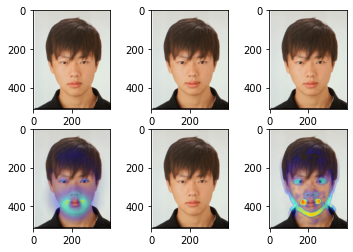

In [604]:
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
ax1.imshow(np.array(resized_original_face))
ax2.imshow(np.array(modified))
ax3.imshow(np.array(reverse))
ax4.imshow(np.array(heatmapped))
ax5.imshow(np.array(y_reverse))
ax6.imshow(np.array(y_heatmapped))
# ax5.imshow(np.array())

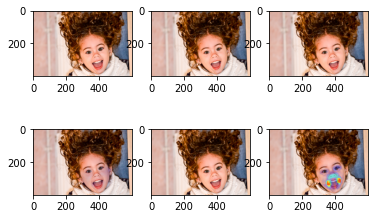

In [590]:
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
ax1.imshow(np.array(resized_original_face))
ax2.imshow(np.array(modified))
ax3.imshow(np.array(reverse))
ax4.imshow(np.array(heatmapped))
ax5.imshow(np.array(y_reverse))
ax6.imshow(np.array(y_heatmapped))
# ax5.imshow(np.array())

In [591]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred_flow, y_flow):
#         loss = torch.linalg.norm(pred_flow[0] -y_flow[0], ord=2)
#         loss += torch.linalg.norm(pred_flow[1] -y_flow[1], ord=2)
#         loss = 0
        loss0 = 0
        loss1 = 0
        sum_a0 = 0
        sum_a1 = 0
        h, w, _ = pred_flow.shape
#         exp_amount = 0
        for i in range(h):
            for j in range(w):
#                 alpha = 1.0
#                 if torch.linalg.norm(y_flow[i][j]) < 1e-4:
#                     alpha = 25.0
#                 loss += alpha*torch.linalg.norm(pred_flow[i][j]-y_flow[i][j])
#                 loss += ((pred_flow[i][j][0] - y_flow[i][j][0]) ** 2 + (pred_flow[i][j][1] - y_flow[i][j][1]) ** 2) ** 0.5
                a0 = torch.exp(-torch.abs(y_flow[i][j][0]))
                a1 = torch.exp(-torch.abs(y_flow[i][j][1]))
                sum_a0 += a0
                sum_a1 += a1
                loss0 += a0 * (((pred_flow[i][j][0] - y_flow[i][j][0]) ** 2) ** 0.5)
                loss1 += a1 * (((pred_flow[i][j][1] - y_flow[i][j][1]) ** 2) ** 0.5)
        loss = (loss0 / sum_a0) + (loss1 / sum_a1)
        return loss
#         return loss / (h*w)

In [592]:
# modified_img_path = './examples/anzu_modified.jpg'
# original_img_path = './examples/anzu_original.jpg'
# modified_img_path = './examples/natsuki_kataoka_modified.png'
# original_img_path = './examples/natsuki_kataoka_original.png'
modified_img_path = './examples/original.jpg'
original_img_path = './examples/modified.jpg'
dest_folder = './out/anzu'
if True:
# Data preprocessing
    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    im_w, im_h = Image.open(modified_img_path).size
    if no_crop:
        face = Image.open(modified_img_path).convert('RGB')
        original_face = Image.open(original_img_path).convert('RGB')
    else:
        faces = face_detection(modified_img_path, verbose=False)
        if len(faces) == 0:
            print("no face detected by dlib, exiting")
            sys.exit()
        face, box = faces[0]
    face = resize_shorter_side(face, 400)[0]
    original_face = resize_shorter_side(original_face, 400)[0]
    face_tens = tf(face).to(device)
    
    # predict flow
    flow = model(face_tens.unsqueeze(0))[0]
    
    
    # calc y_flow
    _, _h, _w = flow.shape
    resized_face = face.resize((_w, _h), Image.BICUBIC)
    resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
    resized_face_np = np.asarray(resized_face)
    resized_original_face_np = np.asarray(resized_original_face)
    resized_face_gray = cv2.cvtColor(resized_face_np,cv2.COLOR_BGR2GRAY)
    resized_original_face_gray = cv2.cvtColor(resized_original_face_np,cv2.COLOR_BGR2GRAY)
    y_flow = cv2.calcOpticalFlowFarneback(resized_face_gray,resized_original_face_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    y_flow_tensor = torch.from_numpy(y_flow)
    y_flow_reshaped = y_flow_tensor.reshape(flow.shape)
    
    # reverse
#     _flow = flow.cpu().detach().numpy()
#     _flow = np.transpose(_flow, (1,2,0))
#     reverse_np = warp(resized_face_np, _flow)
#     reverse_tensor = torch.from_numpy(reverse_np)
#     resized_original_face_tensor = torch.from_numpy(resized_original_face_np)
    
    # cals loss
    custom_loss = CustomLoss()
    loss = custom_loss(flow, - y_flow_reshaped)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _flow = flow
    flow = flow.cpu().detach().numpy()
    flow = np.transpose(flow, (1, 2, 0))
    h, w, _ = flow.shape
    
    # Undoing the warps
    print(f"w is {w} and h is {h}")
    modified = face.resize((w, h), Image.BICUBIC)
    modified_np = np.asarray(modified)
    reverse_np = warp(modified_np, flow)
    reverse = Image.fromarray(reverse_np)
    flow_magn = np.sqrt(flow[:, :, 0]**2 + flow[:, :, 1]**2)
    heatmapped = Image.fromarray(get_heatmap_cv(modified_np, flow_magn, 7))
#     modified_gray = cv2.cvtColor(modified_np,cv2.COLOR_BGR2GRAY)
#     reverse_gray = cv2.cvtColor(reverse_np,cv2.COLOR_BGR2GRAY)
#     cv_flow = cv2.calcOpticalFlowFarneback(modified_gray,reverse_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    y_reverse_np = warp(modified_np, - y_flow)
    y_reverse = Image.fromarray(y_reverse_np)
    y_flow_magn = np.sqrt(y_flow[:, :, 0]**2 + y_flow[:, :, 1]**2)
    y_heatmapped = Image.fromarray(get_heatmap_cv(modified_np, y_flow_magn, 7))

/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_6375/1337313583.py:36: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_6375/1337313583.py:37: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)


w is 600 and h is 400


/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_6375/1337313583.py:68: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  modified = face.resize((w, h), Image.BICUBIC)


In [593]:
def train(model, modified_img_path, original_img_path):
    if True:
    # Data preprocessing
        tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        im_w, im_h = Image.open(modified_img_path).size
        if no_crop:
            face = Image.open(modified_img_path).convert('RGB')
            original_face = Image.open(original_img_path).convert('RGB')
        else:
            faces = face_detection(modified_img_path, verbose=False)
            if len(faces) == 0:
                print("no face detected by dlib, exiting")
                sys.exit()
            face, box = faces[0]
        face = resize_shorter_side(face, 400)[0]
        original_face = resize_shorter_side(original_face, 400)[0]
        face_tens = tf(face).to(device)

        # predict flow
        flow = model(face_tens.unsqueeze(0))[0]


        # calc y_flow
        _, _h, _w = flow.shape
        resized_face = face.resize((_w, _h), Image.BICUBIC)
        resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
        resized_face_np = np.asarray(resized_face)
        resized_original_face_np = np.asarray(resized_original_face)
        resized_face_gray = cv2.cvtColor(resized_face_np,cv2.COLOR_BGR2GRAY)
        resized_original_face_gray = cv2.cvtColor(resized_original_face_np,cv2.COLOR_BGR2GRAY)
        y_flow = cv2.calcOpticalFlowFarneback(resized_face_gray,resized_original_face_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        y_flow_tensor = torch.from_numpy(y_flow)
        y_flow_reshaped = y_flow_tensor.reshape(flow.shape)

        # cals loss
        custom_loss = CustomLoss()
        loss = custom_loss(flow, -y_flow_reshaped)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return model

In [460]:
modified_img_path = './examples/natsuki_kataoka_modified.png'
original_img_path = './examples/natsuki_kataoka_original.png'
train(model, modified_img_path, original_img_path)

/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_6375/675966380.py:30: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_6375/675966380.py:31: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)


DRNSeg(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(3

In [594]:
modified_img_path = './examples/natsuki_kataoka_modified.png'
original_img_path = './examples/natsuki_kataoka_original.png'
modified_img_path = './examples/original.jpg'
original_img_path = './examples/modified.jpg'
for i in tqdm(range(10)):
    train(model, modified_img_path, original_img_path)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_6375/675966380.py:30: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_face = face.resize((_w, _h), Image.BICUBIC)
/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_6375/675966380.py:31: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_original_face = original_face.resize((_w, _h), Image.BICUBIC)
100%|██████████| 10/10 [02:33<00:00, 15.33s/it]


In [595]:
model.state_dict()

OrderedDict([('base.0.weight',
              tensor([[[[ 3.5691e-02, -4.0332e-02, -5.1364e-02,  ...,  3.4462e-02,
                          5.1672e-02,  3.5217e-02],
                        [-2.0466e-02, -9.9552e-02, -9.1930e-02,  ...,  6.2628e-02,
                          1.0977e-01,  8.9458e-02],
                        [-9.3286e-02, -1.8498e-01, -1.5581e-01,  ...,  1.3487e-01,
                          2.2860e-01,  2.1132e-01],
                        ...,
                        [-2.2488e-01, -3.5716e-01, -2.9552e-01,  ...,  1.6792e-01,
                          3.5396e-01,  3.9109e-01],
                        [-1.6935e-01, -2.8886e-01, -2.5839e-01,  ...,  1.2664e-01,
                          2.9514e-01,  3.1577e-01],
                        [-9.4609e-02, -1.9296e-01, -1.7833e-01,  ...,  8.0938e-02,
                          1.8075e-01,  1.9512e-01]],
              
                       [[-3.2623e-02, -8.8016e-02, -7.5201e-02,  ...,  2.7827e-02,
                          5.454

In [401]:
model.state_dict()

OrderedDict([('base.0.weight',
              tensor([[[[ 3.5756e-02, -4.0266e-02, -5.1299e-02,  ...,  3.4526e-02,
                          5.1736e-02,  3.5281e-02],
                        [-2.0401e-02, -9.9487e-02, -9.1865e-02,  ...,  6.2693e-02,
                          1.0983e-01,  8.9522e-02],
                        [-9.3222e-02, -1.8492e-01, -1.5575e-01,  ...,  1.3494e-01,
                          2.2866e-01,  2.1139e-01],
                        ...,
                        [-2.2481e-01, -3.5709e-01, -2.9546e-01,  ...,  1.6798e-01,
                          3.5402e-01,  3.9116e-01],
                        [-1.6929e-01, -2.8880e-01, -2.5832e-01,  ...,  1.2671e-01,
                          2.9520e-01,  3.1583e-01],
                        [-9.4545e-02, -1.9289e-01, -1.7826e-01,  ...,  8.1001e-02,
                          1.8082e-01,  1.9518e-01]],
              
                       [[-3.2579e-02, -8.7971e-02, -7.5157e-02,  ...,  2.7870e-02,
                          5.458